# Game class

In [109]:
import numpy as np
import random

In [110]:
# Global controls

ACTION_NAMES = ["left", "up", "right", "down"]
ACTION_LEFT = 0
ACTION_UP = 1
ACTION_RIGHT = 2
ACTION_DOWN = 3

In [111]:
class Game(object):
    def __init__(self, state=None, initial_score=0):
        """Init the Game object.
        Args:
        state: Shape (4, 4) numpy array to initialize the state with. If None,
        the state will be initialized with two random tiles (as done
        in the original game).
        initial_score: Score to initialize the Game with.
        """
        self._score = initial_score

        if state is None:
            # Initialize all states to 0(empty)
            self._state = np.zeros((4, 4), dtype=np.int)
            
            # Initialize 2 random tiles
            self.add_random_tile()
            self.add_random_tile()
        else:
            self._state = state

    def copy(self):
        """Return a copy of self."""
        return Game(np.copy(self._state), self._score)

    def game_over(self):
        """Whether the game is over. Check if any of the actions are still available"""
        for action in range(4):
            if self.is_action_available(action):
                return False
        return True

    def available_actions(self):
        """Computes the set of actions that are available."""
        return [action for action in range(4) if self.is_action_available(action)]

    def is_action_available(self, action):
        """Determines whether action is available.
        That is, executing it would change the state.
        """
        # Rotate the state by 90 anti clockwise times the action 
        # This reduces the number of cases to be checked
        temp_state = np.rot90(self._state, action)
        return self._is_action_available_left(temp_state)

    def _is_action_available_left(self, state):
        """Determines whether action 'Left' is available."""

    # True if any field is 0 (empty) on the left of a tile or two tiles can
    # be merged.
        for row in range(4):
            has_empty = False
            for col in range(4):
                has_empty |= state[row, col] == 0
                if state[row, col] != 0 and has_empty:
                    return True
                if (state[row, col] != 0 and col > 0 and
                    state[row, col] == state[row, col - 1]):
                    return True

        return False


    def do_action(self, action):
        """Execute action, add a new tile, update the score & return the reward."""

        temp_state = np.rot90(self._state, action)
        reward = self._do_action_left(temp_state)
        self._state = np.rot90(temp_state, -action)
        self._score += reward

        self.add_random_tile()

        return reward

    def _do_action_left(self, state):
        """Exectures action 'Left'."""

        reward = 0

        for row in range(4):
          # Always the rightmost tile in the current row that was already moved
            merge_candidate = -1
            merged = np.zeros((4,), dtype=np.bool)

            for col in range(4):
                if state[row, col] == 0:
                    continue

                if (merge_candidate != -1 and
                    not merged[merge_candidate] and
                    state[row, merge_candidate] == state[row, col]):
                  # Merge tile with merge_candidate
                    state[row, col] = 0
                    merged[merge_candidate] = True
                    state[row, merge_candidate] += 1
                    reward += 2 ** state[row, merge_candidate]

                else:
                  # Move tile to the left
                    merge_candidate += 1
                    if col != merge_candidate:
                        state[row, merge_candidate] = state[row, col]
                        state[row, col] = 0

        return reward

    def add_random_tile(self):
        """Adds a random tile to the grid. Assumes that it has empty fields."""

        x_pos, y_pos = np.where(self._state == 0)
        assert len(x_pos) != 0
        empty_index = np.random.choice(len(x_pos))
        value = np.random.choice([1, 2], p=[0.9, 0.1])

        self._state[x_pos[empty_index], y_pos[empty_index]] = value

    def print_state(self):
        """Prints the current state."""

        def tile_string(value):
          """Concert value to string."""
          if value > 0:
            return '% 5d' % (2 ** value,)
          return "     "

        print("-" * 25)
        for row in range(4):
            print("|" + "|".join([tile_string(v) for v in self._state[row, :]]) + "|")
            print("-" * 25)

    def state(self):
        """Return current state."""
        return self._state

    def score(self):
        """Return current score."""
        return self._score

In [112]:
game = Game()

In [113]:
game.print_state()

-------------------------
|     |    2|     |     |
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |    4|
-------------------------
|     |     |     |     |
-------------------------


In [114]:
x = game.do_action(2)
print(x)
game.print_state()

0
-------------------------
|     |     |     |    2|
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |    4|
-------------------------
|    2|     |     |     |
-------------------------


In [147]:
class Agent():
    "All of the Agent expect Q-learning has been given to you."
    def __init__(self, game_class, epsilon=0.1, alpha=1.0):
        self.V = dict() # Build up the values of different states as we encounter them; Note the Markov assumption
        self.NewGame = game_class
        self.epsilon = epsilon
        self.alpha = alpha

    def state_value(self, game_state, action):
        "Look up state value. If never seen state, then assume neutral."
        return self.V.get((str(game_state), action), 0.0) 

    def learn_game(self, n_episodes=1_000):
        "Let's learn through complete experience to get that reward."
        for episode in range(n_episodes):
            self.learn_from_episode()

    def learn_from_episode(self):
        "Update Values based on reward."
        game = self.NewGame()
        while not game.game_over():
            action, reward = self.learn_from_move(game)
        self.V[(str(game._state), action)] = reward

    def learn_from_move(self, game):
        "The heart of Q-learning."
        
        current_state = game._state
        selected_next_move = self.learn_select_move(game)
        r = game.do_action(selected_next_move)
        current_state_value = self.state_value(current_state,selected_next_move)
        
        try:
            best_next_move = self.select_best_move(game)
                                               
            best_move_value = self.state_value(game._state, best_next_move)
            td_target = r + best_move_value
            self.V[(str(current_state), selected_next_move)] = current_state_value + self.alpha * (td_target - current_state_value) 
        except:
            pass
        return selected_next_move, r
        
    def learn_select_move(self, game):
        "Exploration and exploitation"
        best_state_action = self.select_best_move(game)
        selected_state_action = best_state_action
        if random.random() < self.epsilon:
            allowed_state_action_values = self.state_values( game._state, game.available_actions())
            selected_state_action = self.random_V(allowed_state_action_values)[1]
        return selected_state_action
    
    def select_best_move(self, game):
        allowed_state_action_values = self.state_values( game._state, game.available_actions() )
        best_state_action = self.argmax_V(allowed_state_action_values)
        return best_state_action[1]

    def round_V(self):
        "After training, this makes action selection random from equally-good choices"
        for k in self.V.keys():
            self.V[k] = round(self.V[k],1)

    def state_values(self, game_state, actions):
        return dict(((str(game_state), action), self.state_value(game_state, action)) for action in actions)

    def argmax_V(self, state_values):
        "For the best possible states, chose randomly amongst them."
        try:
            max_V = max(state_values.values())
        except:
            max_V = 0
        chosen_state_action = random.choice([state_action for state_action, v in state_values.items() if v == max_V])
        return chosen_state_action

    def random_V(self, state_values):
        "Any state will do."
        return random.choice(list(state_values.keys()))
    
    def random_play(self):
        game = self.NewGame()
        while not game.game_over():
            self.random_move(game)
        return game.score()
    
    def random_move(self, game):
        available = game.available_actions()
        game.do_action(np.random.choice(available))
    
    def q_learning_play(self):
        game = self.NewGame()
        while not game.game_over():
            best = self.select_best_move(game)
            if best in game.available_actions():
                game.do_action(best)
            else:
                game.do_action(np.random.choice(game.available_actions()))
        return game.score()          


In [178]:
a = Agent(Game)

## Random Play

In [179]:
score = []
for i in range(100):
    score.append(a.random_play())

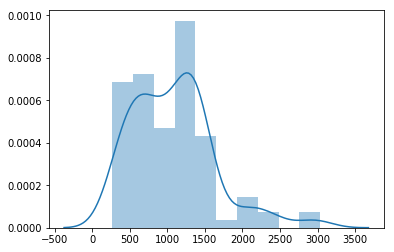

In [153]:
import seaborn as sns
sns.distplot(score)

In [180]:
print("Mean score {}".format(np.mean(score)))

Mean score 1051.2


## Q- learning

In [170]:
a = Agent(Game)
a.learn_game(5000)

In [171]:
len(a.V)

488844

In [172]:
score = []
for i in range(100):
    score.append(a.q_learning_play())

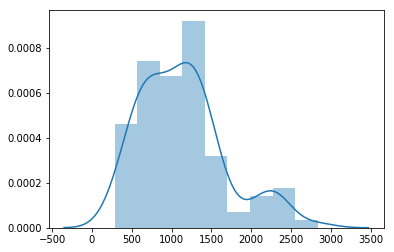

In [173]:
sns.distplot(score)

In [176]:
print("Mean score {}".format(np.mean(score)))

Mean score 1131.24
